### Modelling the Galactic LMXB distribution

In [26]:
import os
from multiprocessing import Pool
import pickle


import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

import scipy.integrate as integrate
import astropy.units as u
import astropy.coordinates as coord 
import healpy as hp
%matplotlib notebook

We follow https://ui.adsabs.harvard.edu/abs/2019MNRAS.484...19J and use https://ui.adsabs.harvard.edu/abs/2002A%26A...391..923G/abstract to construct a function which provides probabilistic samples of LMXB positions and distances.  Grimm+02 has a typo for the disk distribution; we use the correct version from https://ui.adsabs.harvard.edu/abs/1998MNRAS.294..429D/abstract.

In [3]:
def rho_bulge(r, z, rho0_bulge=1.9789*1e9, r0=1.0, q=0.6, gamma=1.8, rt=1.9):
    """Bulge density model from Grimm et al. 2002 (Eqn. 4)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_bulge * (np.sqrt(r**2. + z**2./q**2.)/r0)**(-1.*gamma) * np.exp(-1. * (r**2. + z**2./q**2.)/rt**2.)

def rho_disk(r, z, rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Disk density model from Grimm et al. 2002 (Eqn. 5).  
    
    Note a typo in the Grimm+02 paper; we include the correct version from Dehnen & Binney (1998)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_disk * np.exp(-1.*rm/rd - r/rd - np.abs(z)/rz)

def mass_disk(rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Integrated mass of disk from Dehnen & Binney (1998) eqn. 2
    
    Parameters
    ----------
    
    Returns
    -------
    density in solar masses
    
    """
    from scipy.special import kn
    
    sigma_d = rho0_disk * 2 * rz
    
    return 4*np.pi*sigma_d*rm*rd* kn(2,2*np.sqrt(rm/rd))

def rho_sphere(r, z, rho0_sphere=8.74*1e9, b=7.669, Re=2.8):
    """Disk density model from Grimm et al. 2002 (Eqn. 6)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    R = np.sqrt(r**2. + z**2.)
    
    return rho0_sphere * np.exp(-1.*b*(R/Re)**(1/4)) / (R/Re)**(7/8)

Integrate numerically to get total masses.  Integrate in Galactocentric cylindrical coordinates from r ∊ 0,15 kpc, z ∊ -15,15 kpc

In [4]:
bulge_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_bulge(r,z), -15, 15, lambda r: 0, lambda r: 15)[0] 
disk_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_disk(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  
sphere_mass = 2*np.pi*integrate.dblquad(lambda r, z: r * rho_sphere(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  

Compare our numerical integral to the analytic value... not perfect

In [5]:
mass_disk()/disk_mass

2.2802363085057036

MJ reports that they could not reproduce the Grimm mass ratios with the provided normalizations.  We will follow them and use the [Picaurd & Robin 04](https://ui.adsabs.harvard.edu/abs/2004A%26A...428..891P/abstract) bulge mass estimate of 2.4e10 Msun, and adjust the other normalizations to match ratios of 2:1:0.3.

In [6]:
print(f'{bulge_mass:.2e} {disk_mass:.2e} {sphere_mass:.2e}')

2.40e+10 1.20e+10 3.60e+09


In [7]:
bulge_mass/disk_mass

1.9999954308634986

In [8]:
sphere_mass/disk_mass

0.2998325450823631

## load 3-d extinction maps and test them

we will use a fork of https://github.com/willclarkson/rubinCadenceScratchWIC

In [9]:
import sys
sys.path.append('../python')
import readExtinction

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
pathReddening = '../data/merged_ebv3d_nside64.fits'
print(pathReddening, os.access(pathReddening, os.R_OK))

../data/merged_ebv3d_nside64.fits True


In [12]:
ebv = readExtinction.ebv3d(pathReddening)
ebv.loadMap()

<IPython.core.display.Javascript object>


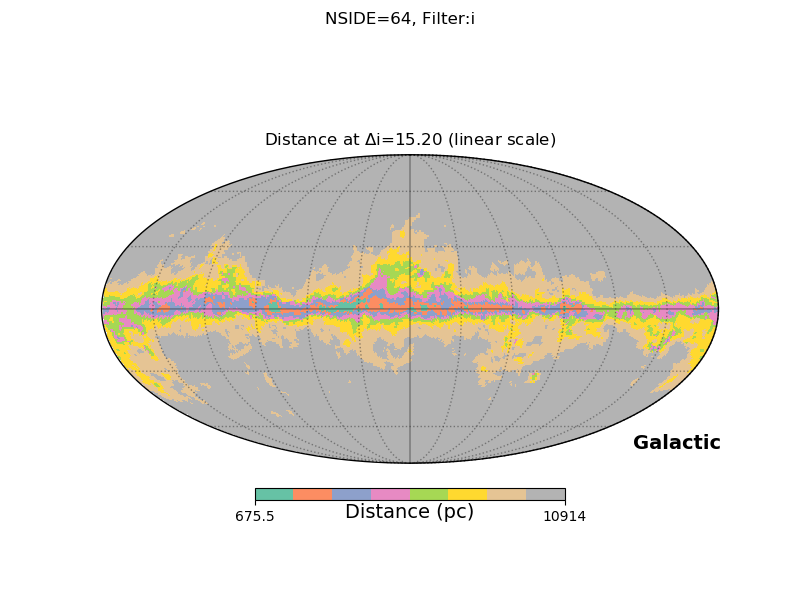

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


array([8585.23747277, 8483.37065217, 9058.13586957, ..., 9483.90305011,
       9412.00980392, 9273.67282609])

In [13]:
readExtinction.testDeltamags('i', 15.2, cmap='Set2', pathMap=pathReddening)

In [17]:
readExtinction.testReadExt(False, pathMap=pathReddening)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The inter

In [18]:
dir(ebv)

['R_x',
 'Verbose',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calcDistmods',
 'dists',
 'dmods',
 'ebvs',
 'getDeltaMag',
 'getDistanceAtMag',
 'getEBVatSightline',
 'getInterpolatedProfile',
 'getMapNearestDist',
 'getMaxDistDeltaMag',
 'hdr',
 'hpids',
 'loadMap',
 'mask',
 'nested',
 'nside',
 'pathMap',
 'sfacs',
 'showDistanceInterval',
 'showMollview']

In [19]:
readExtinction.testShowDistresol( pathMap=pathReddening)

## determine distances to which we can see extincted K-stars.

We use the Johnson et al. 2019 absolute magnitudes for an LMXB with a K-type companion + disk in the LSST bands:

In [20]:
lmxb_abs_mag_r = 4.6
lmxb_abs_mags = {'u':lmxb_abs_mag_r + 4.14,
                 'g':lmxb_abs_mag_r + 3.24,
                 'r':lmxb_abs_mag_r,
                 'i':lmxb_abs_mag_r + 0.33,
                 'z':lmxb_abs_mag_r + 1.05,
                 'y':lmxb_abs_mag_r + 2.36
                 }

Next we load the limiting magnitudes per filter (taken from the Ivezic et al. 2019):

In [21]:
lsst_single_epoch_depth =  {'u':23.9,
                            'g':25.0,
                            'r':24.7,
                            'i':24.0,
                            'z':23.3,
                            'y':22.1
                            }

lsst_ten_year_depth =  {'u':26.1,
                        'g':27.4,
                        'r':27.5,
                        'i':26.8,
                        'z':26.1,
                        'y':24.9
                        }

The fiducial single-epoch depths are a compromise here: they are optimistic in the crowded regions of the Plane, but pessimistic when considering what can be achieved with forced photometry in data releases.  MAF has tools for assessing crowding but they are tied to specific OpSim runs in a way which is inconvenient for this purpose.

In [22]:
delta_mags = {}
for filt, M in lmxb_abs_mags.items():
    delta_mags[filt] = lsst_single_epoch_depth[filt] - M

In [23]:
delta_mags

{'u': 15.16,
 'g': 17.16,
 'r': 20.1,
 'i': 19.07,
 'z': 17.650000000000002,
 'y': 15.140000000000002}

<IPython.core.display.Javascript object>


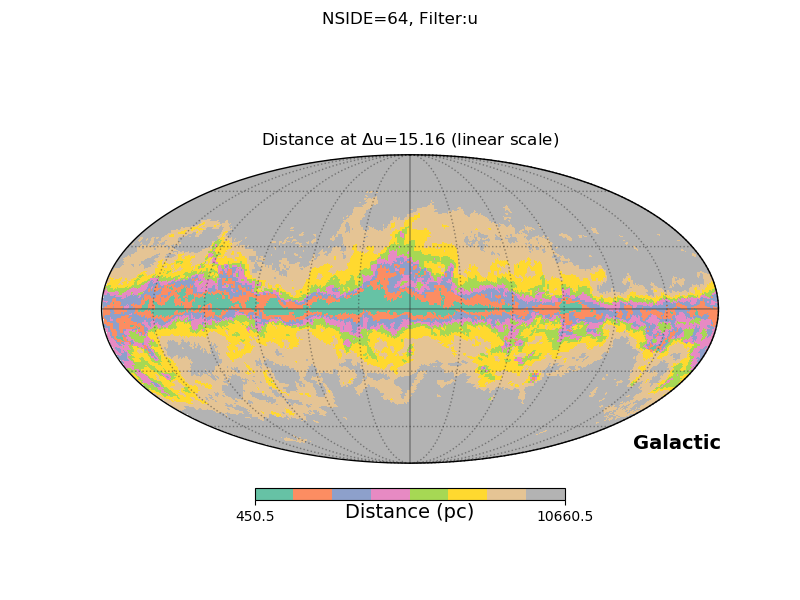

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


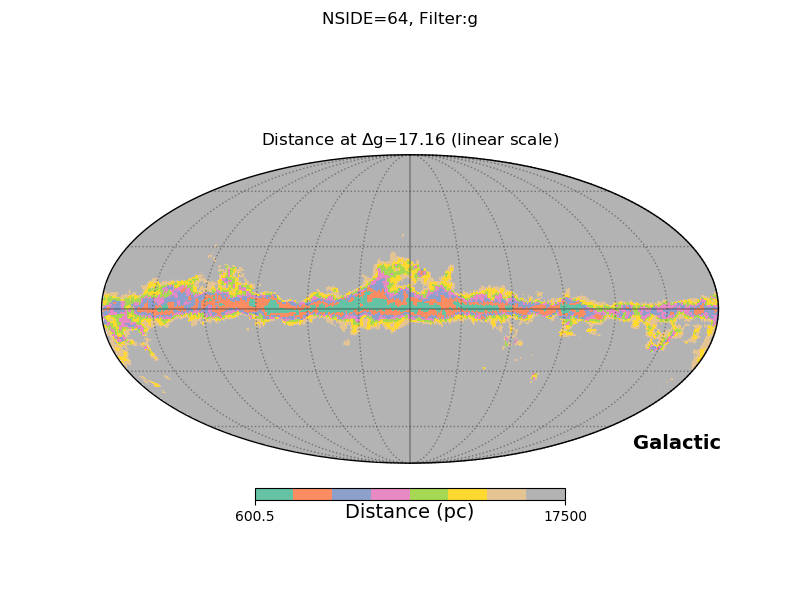

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


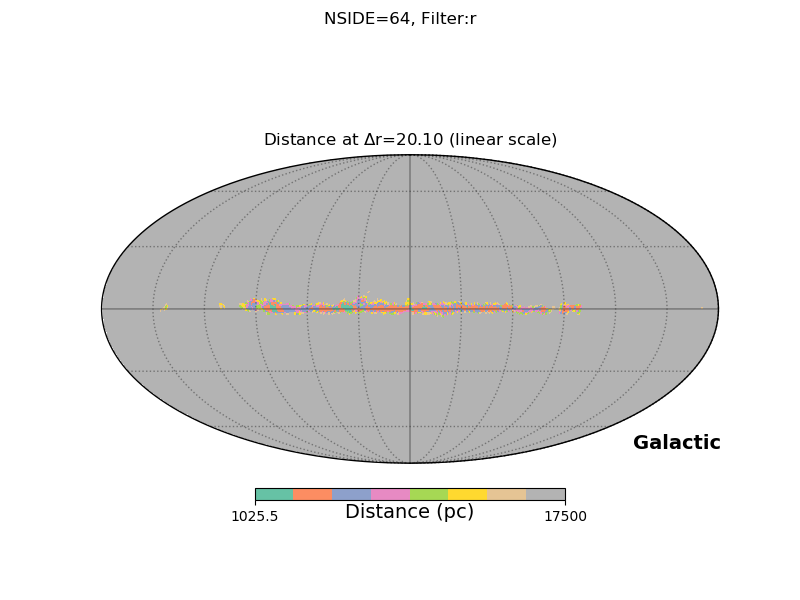

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


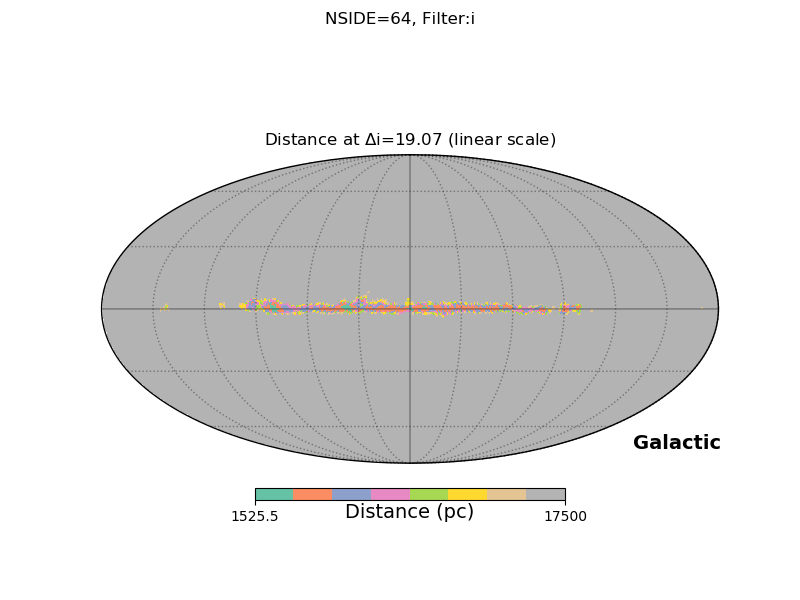

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


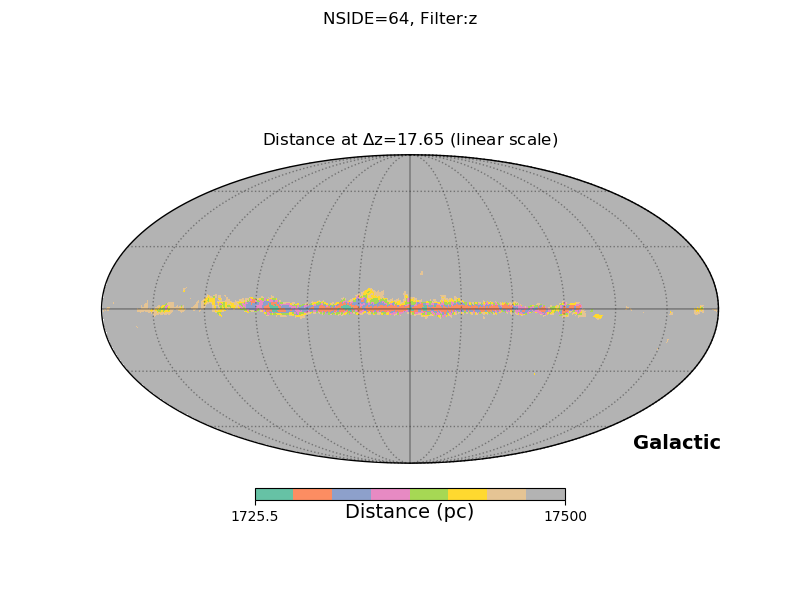

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


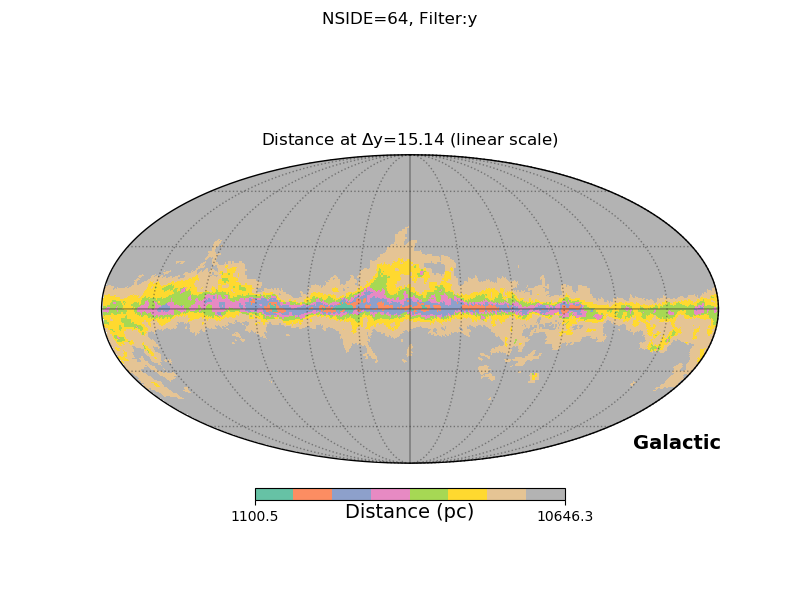

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [24]:
distance_to_deltamag = {}
for filt, dmag in delta_mags.items():
    distance_to_deltamag[filt] = readExtinction.testDeltamags(filt, dmag, cmap='Set2', pathMap=pathReddening)

In [25]:
distance_to_deltamag['u']

array([6068.97385621, 5932.85      , 6902.76630435, ..., 7650.62527233,
       7542.78540305, 7261.99456522])

## Convert to relative spatial density in l, b for the TVS Plane metric

We want to integrate our Galaxy model of stellar density from 0 to the max distance we can see K-dwarfs in LSST single-epoch images, due to extinction.

Ideally the nearby distance would be the saturation limit but I expect this is a relatively minor effect.

<IPython.core.display.Javascript object>


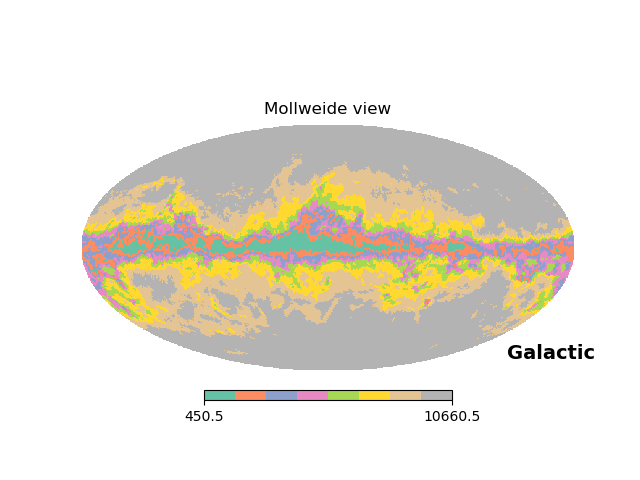

In [30]:
hp.mollview(distance_to_deltamag['u'], plt.figure(), coord=['C','G'],cmap='Set2',hold=True)

In [31]:
# get the coordinates of the healpix distance maps we've made
NSIDE=64
hp_ra, hp_dec = hp.pix2ang(NSIDE,np.arange(hp.nside2npix(NSIDE)),lonlat=True)

<IPython.core.display.Javascript object>


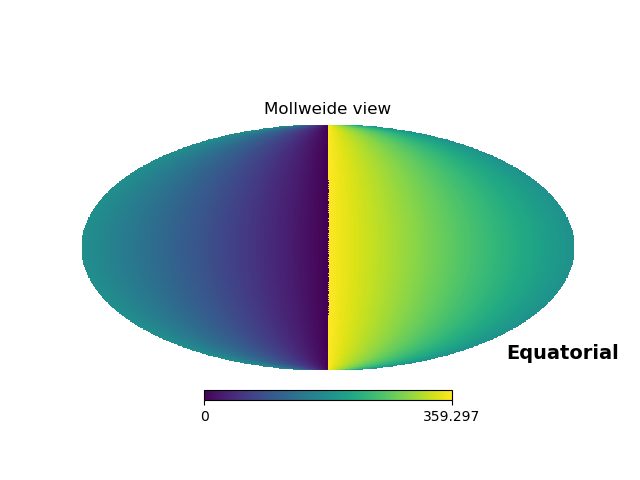

In [33]:
hp.mollview(hp_ra, plt.figure(), coord=['C'],hold=True)

<IPython.core.display.Javascript object>


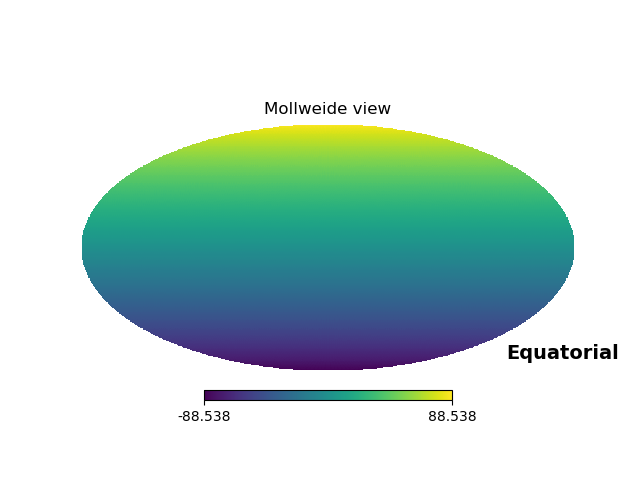

In [34]:
hp.mollview(hp_dec, plt.figure(), coord=['C'],hold=True)

If running this again, look at discussion here: https://docs.astropy.org/en/stable/coordinates/inplace.html for potential speedups by modifying objects rather than instantiating new ones 

In [47]:
def local_density(sc_in, distance_pc):
    
    # doing the coordinate conversion inside the integration loop is expensive...
    sc = coord.SkyCoord(sc_in.ra, sc_in.dec, distance_pc, frame='icrs', unit=('deg','deg','pc'))
    sc_gc = sc.transform_to(coord.Galactocentric)
    r = np.sqrt(sc_gc.x**2. + sc_gc.y**2.).to(u.kiloparsec).value
    z = (sc_gc.z).to(u.kiloparsec).value
    
    return rho_bulge(r,z) + rho_disk(r,z) + rho_sphere(r,z)

In [48]:
def integrate_density(sc,dmax,NSIDE=64):
    
    return integrate.quad(lambda d: d**2. * local_density(sc, d), 0, dmax)[0] \
        * hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)

In [49]:
%%time
filters = ['u','g','r','i','z','y']
integrals = {}
with Pool(processes=32) as pool:
    for filt in filters:
        integral = []
        integral = pool.starmap(integrate_density, zip(hp_sc, distance_to_deltamag[filt]))
        integrals[filt] = integral

FloatProgress(value=0.0)


CPU times: user 1min 46s, sys: 45.8 s, total: 2min 31s
Wall time: 6h 51min 40s


In [50]:
integrals.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'y'])

In [52]:
#with open('raw_integrals.pickle', 'wb') as handle:
#    pickle.dump(integrals, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [28]:
with open('raw_integrals.pickle', 'rb') as handle:
    integrals = pickle.load(handle)

In [29]:
type(integrals['g'])

list

<IPython.core.display.Javascript object>


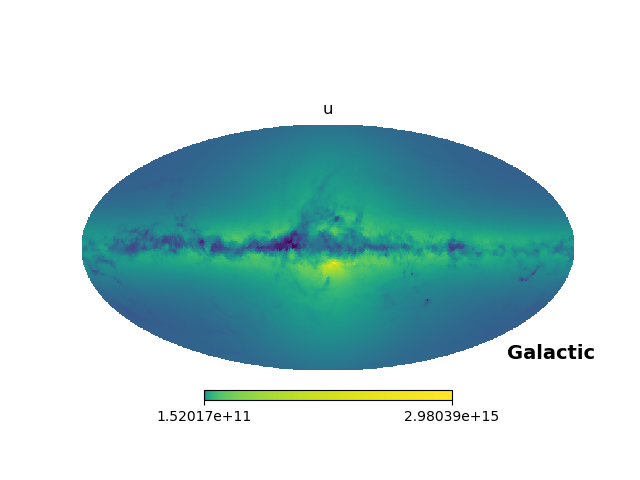

<IPython.core.display.Javascript object>


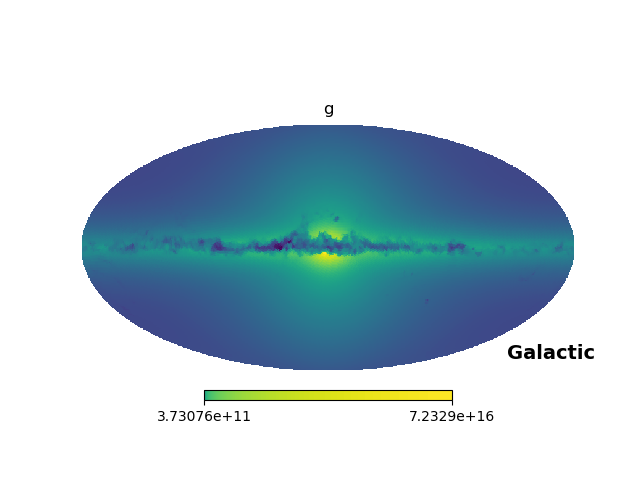

<IPython.core.display.Javascript object>


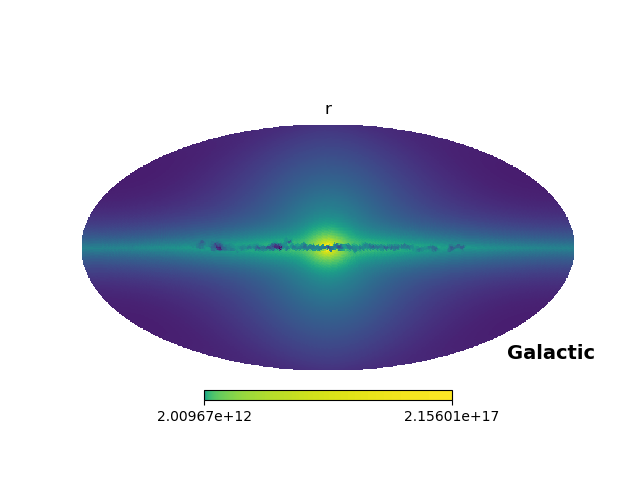

<IPython.core.display.Javascript object>


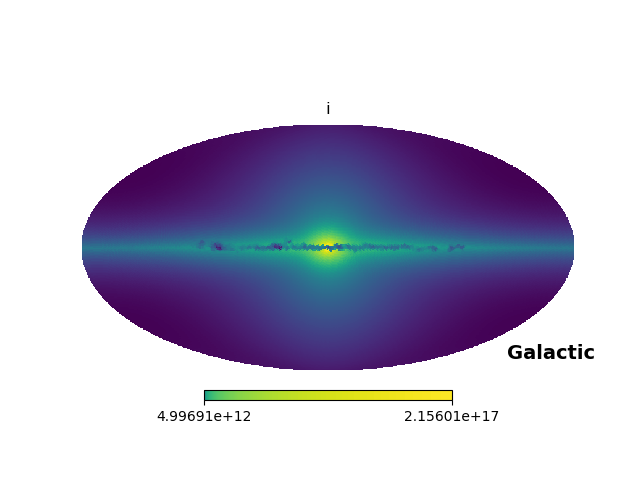

<IPython.core.display.Javascript object>


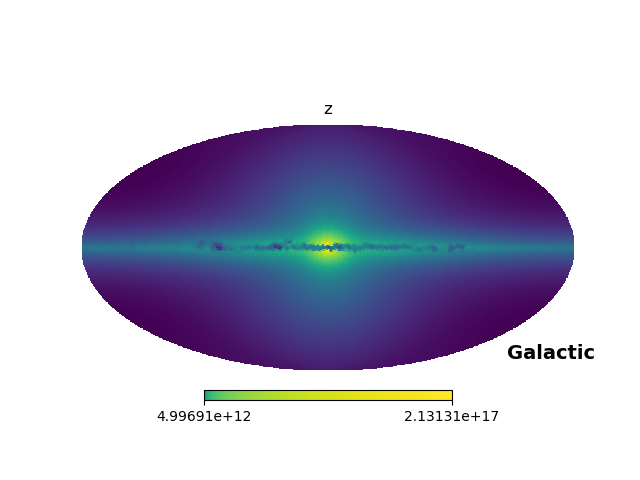

<IPython.core.display.Javascript object>


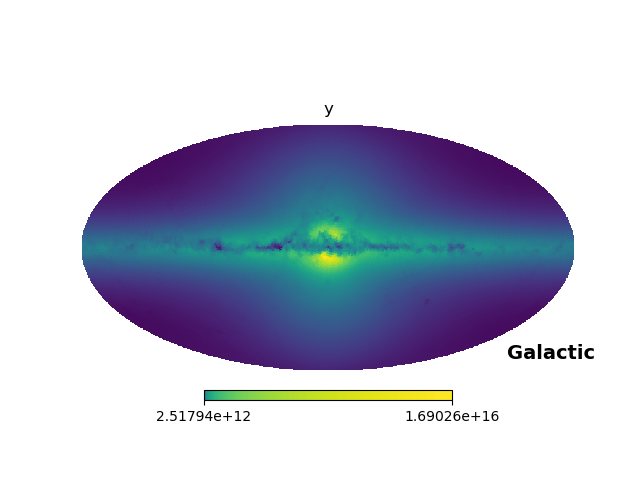

In [30]:
for filt in ['u','g','r','i','z','y']:
    hp.mollview(np.array(integrals[filt]), plt.figure(), coord=['C','G'],hold=True,title=filt,norm='log')

Now normalize all of them by the total masses

In [31]:
totmass = np.sum([np.sum(integral) for integral in integrals.values()])

In [32]:
totmass

7.724945106547225e+19

In [33]:
normed_maps = {filt:np.array(integral)/totmass for filt,integral in integrals.items()}

<IPython.core.display.Javascript object>


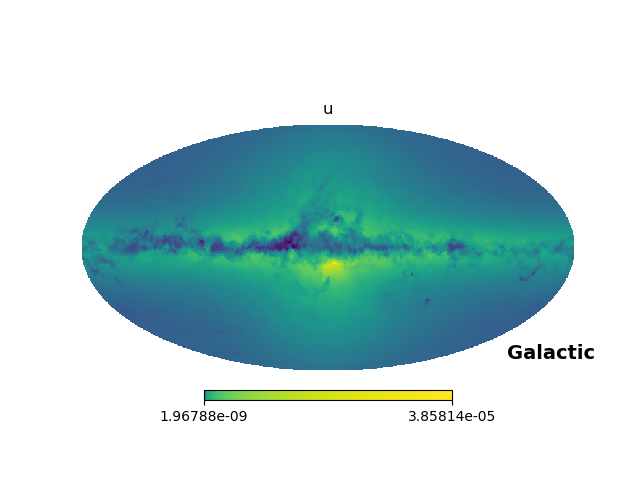

<IPython.core.display.Javascript object>


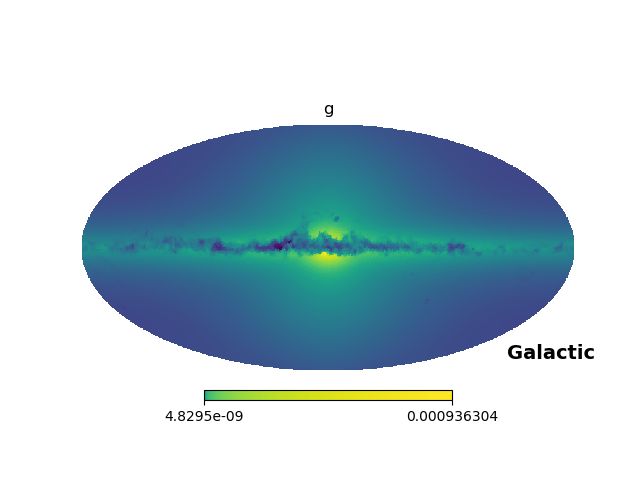

<IPython.core.display.Javascript object>


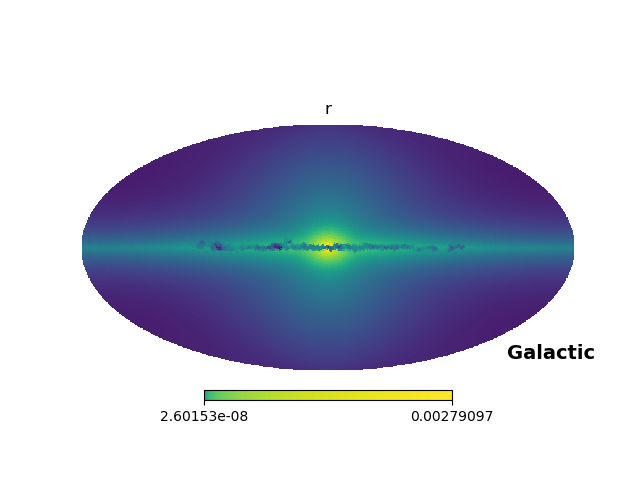

<IPython.core.display.Javascript object>


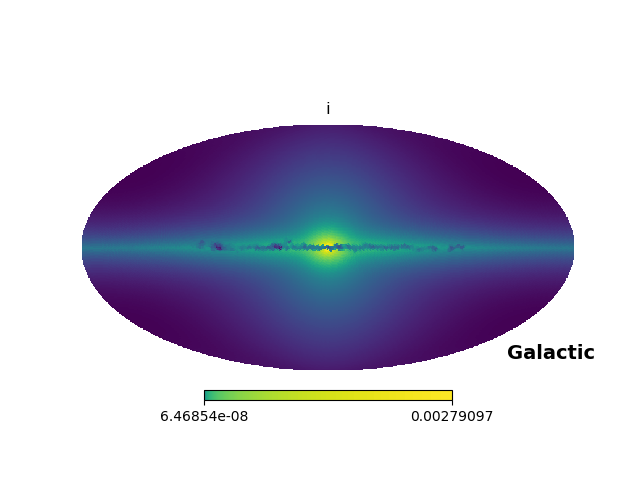

<IPython.core.display.Javascript object>


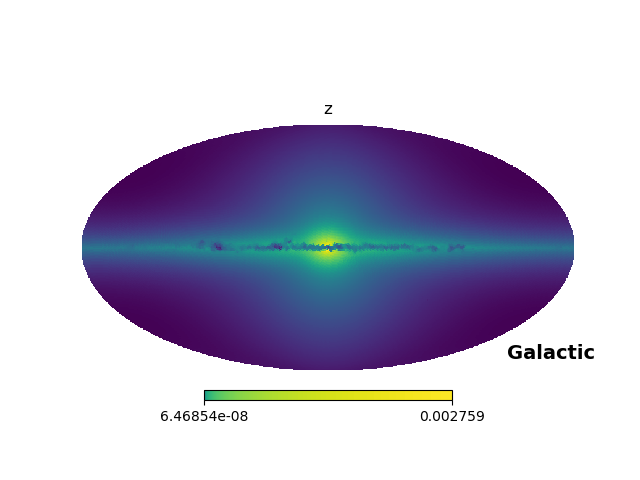

<IPython.core.display.Javascript object>


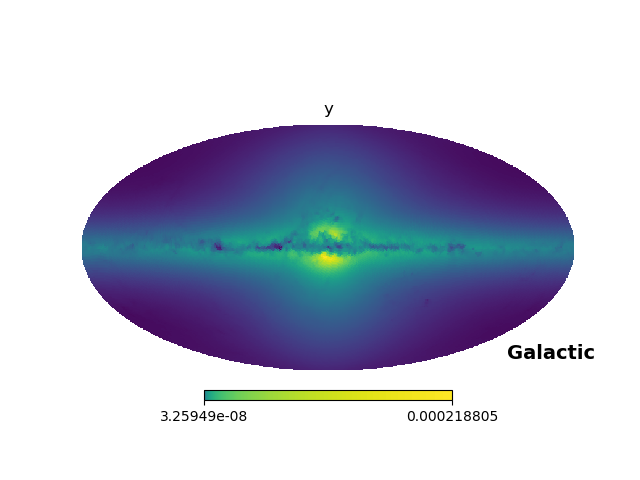

In [34]:
for filt in ['u','g','r','i','z','y']:
    hp.mollview(normed_maps[filt], plt.figure(), coord=['C','G'],hold=True,title=filt,norm='log')

In [35]:
for filt in ['u','g','r','i','z','y']:
    print(f'{filt}: {np.sum(normed_maps[filt])}')

u: 0.0173768912417772
g: 0.0982102700908432
r: 0.2763177823390932
i: 0.2884491737908149
z: 0.26087470871221674
y: 0.05877117382525461


In [85]:
for filt in ['u','g','r','i','z','y']:
    hp.fitsfunc.write_map(f'xrb_priority_map_{filt}.fits',normed_maps[filt],coord='C')

## Construct Probabilistic Sample of XRB locations

For our outburst metric, we'd like a probability-weighted sample of event locations throughout the galaxy.

## Build density grid

In [21]:
grid_coords = np.linspace(-15,15,301) # in kpc
grid_coords

array([-15. , -14.9, -14.8, -14.7, -14.6, -14.5, -14.4, -14.3, -14.2,
       -14.1, -14. , -13.9, -13.8, -13.7, -13.6, -13.5, -13.4, -13.3,
       -13.2, -13.1, -13. , -12.9, -12.8, -12.7, -12.6, -12.5, -12.4,
       -12.3, -12.2, -12.1, -12. , -11.9, -11.8, -11.7, -11.6, -11.5,
       -11.4, -11.3, -11.2, -11.1, -11. , -10.9, -10.8, -10.7, -10.6,
       -10.5, -10.4, -10.3, -10.2, -10.1, -10. ,  -9.9,  -9.8,  -9.7,
        -9.6,  -9.5,  -9.4,  -9.3,  -9.2,  -9.1,  -9. ,  -8.9,  -8.8,
        -8.7,  -8.6,  -8.5,  -8.4,  -8.3,  -8.2,  -8.1,  -8. ,  -7.9,
        -7.8,  -7.7,  -7.6,  -7.5,  -7.4,  -7.3,  -7.2,  -7.1,  -7. ,
        -6.9,  -6.8,  -6.7,  -6.6,  -6.5,  -6.4,  -6.3,  -6.2,  -6.1,
        -6. ,  -5.9,  -5.8,  -5.7,  -5.6,  -5.5,  -5.4,  -5.3,  -5.2,
        -5.1,  -5. ,  -4.9,  -4.8,  -4.7,  -4.6,  -4.5,  -4.4,  -4.3,
        -4.2,  -4.1,  -4. ,  -3.9,  -3.8,  -3.7,  -3.6,  -3.5,  -3.4,
        -3.3,  -3.2,  -3.1,  -3. ,  -2.9,  -2.8,  -2.7,  -2.6,  -2.5,
        -2.4,  -2.3,

In [22]:
# make galactocentric xyz coords for all grid points
gx, gy, gz = np.meshgrid(grid_coords,grid_coords,grid_coords)

In [23]:
gx.shape

(301, 301, 301)

In [24]:
gr = np.sqrt(gx**2. + gy**2.)

In [25]:
gr.shape

(301, 301, 301)

In [26]:
density = rho_bulge(gr,gz) + rho_disk(gr,gz) + rho_sphere(gr,gz)

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide


In [27]:
density.shape

(301, 301, 301)

In [28]:
density.dtype

dtype('float64')

In [29]:
density.min()

1914.2793186649649

In [30]:
density.max()

inf

In [31]:
winf = np.argwhere(np.isinf(density))

In [32]:
winf

array([[150, 150, 150]])

In [33]:
winf.shape

(1, 3)

In [34]:
density[winf[0,0],winf[0,1],winf[0,2]]

inf

r,z = 0 is infinite, so just replace it with the largest non-infinte value

In [35]:
density[winf[0,0],winf[0,1],winf[0,2]] = np.max(density[np.isfinite(density)])
density[winf[0,0],winf[0,1],winf[0,2]]

130466988212.66547

Now to convert to probabilty.  For ease we will flatten the array; then get the argsort and normalized cumsum.

In [36]:
flat_density = density.flatten()

In [37]:
flat_prob_density = flat_density/np.sum(flat_density)

In [38]:
flat_prob_density.sum(), flat_prob_density.max()

(0.9999999999999981, 0.0033004210631848068)

In [39]:
# reshape back to 3d grid
prob_density_grid = flat_prob_density.reshape(density.shape)

In [40]:
#check that the galactic center is near our max probability
prob_density_grid[150,150,150]

0.0033004210631848068

### Rejection sample the grid

Now we will draw xyz voxels at random with replacement, and use numpy's `rng.choice` to select those elements which are most likely.

(We will later randomize positions relative to the voxel xyz coords for higher fidelity)

In [41]:
rng = default_rng()

In [42]:
flat_idx = np.arange(len(flat_prob_density))

In [49]:
nsamples = 10000000
sample_voxel_inds = rng.choice(flat_idx,nsamples,replace=True,p=flat_prob_density)

In [50]:
sample_voxel_inds

array([13637255, 13816351, 11727108, ..., 13273647, 13546953,  6884015])

In [51]:
flat_prob_density[sample_voxel_inds]

array([1.13367539e-04, 7.70924236e-04, 2.31562335e-06, ...,
       1.89742712e-04, 5.73917061e-05, 1.47576220e-08])

Now we want to convert these flattened indices back to xyz coordinates.

In [55]:
sample_xi, sample_yi, sample_zi = np.unravel_index(sample_voxel_inds,shape=density.shape)

<IPython.core.display.Javascript object>


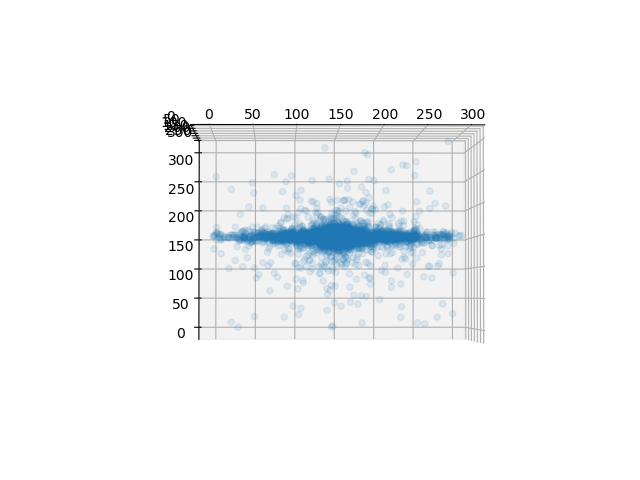

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sample_xi[:10000],sample_yi[:10000],sample_zi[:10000],alpha=0.1)

In [57]:
sample_xi

array([150, 152, 129, ..., 146, 149,  75])

In [64]:
# convert back to kpc and randomize around the voxel spacing
sample_x = grid_coords[sample_xi] + (0.1*rng.random(nsamples)-0.05)
sample_y = grid_coords[sample_yi] + (0.1*rng.random(nsamples)-0.05)
sample_z = grid_coords[sample_zi] + (0.1*rng.random(nsamples)-0.05)

<IPython.core.display.Javascript object>


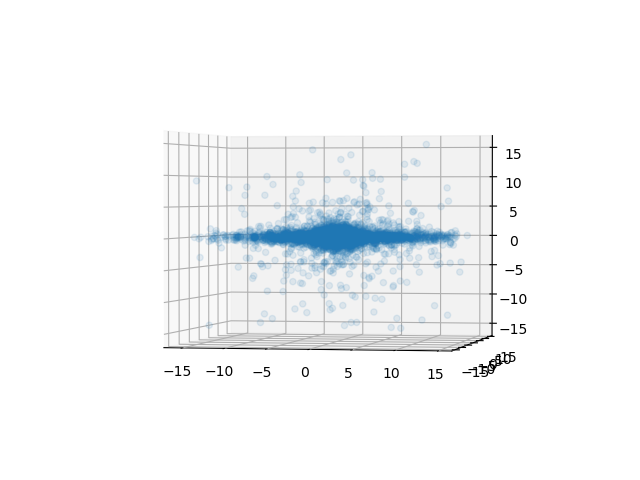

In [65]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sample_x[:10000],sample_y[:10000],sample_z[:10000],alpha=0.1)

Now we want to make SkyCoords out of these samples and convert to ra, dec, distance.

In [68]:
sample_sc_gc = coord.SkyCoord(sample_x, sample_y, sample_z, unit='kpc', frame=coord.Galactocentric)

In [74]:
sample_sc = sample_sc_gc.transform_to(coord.ICRS) 
sample_sc_lb = sample_sc_gc.transform_to(coord.Galactic) 

<IPython.core.display.Javascript object>


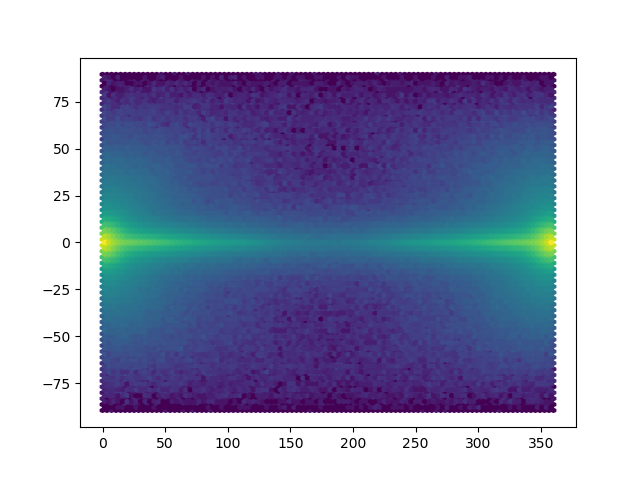

In [77]:
plt.figure()
plt.hexbin(sample_sc_lb.l,sample_sc_lb.b,norm=colors.LogNorm())

<IPython.core.display.Javascript object>


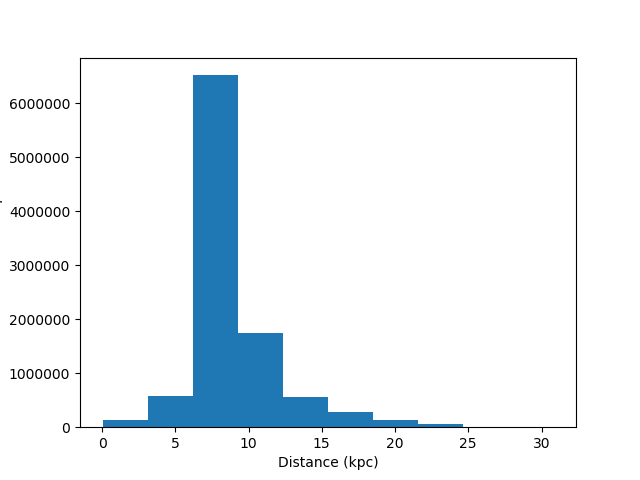

Text(0, 0.5, 'Number of samples')

In [87]:
plt.figure()
plt.hist(sample_sc.distance.value)
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of samples')

In [84]:
sample_sc.distance.value

array([ 8.29154367,  8.45353556,  6.49433094, ...,  7.86516109,
        8.2269108 , 14.48647264])

In [89]:
sample_table = sample_sc.to_table()
# not in the current version I'm afraid

AttributeError: 'SkyCoord' object has no attribute 'to_table'

now use the dust maps to retrieve E(B-V) at these positions

In [138]:
sample_ebv = np.ones(nsamples)*np.nan

In [132]:
# due to have the ebv maps are stored it will work best if we loop these by distance
ebv_dists = ebv.dists[0,:]

In [133]:
ebv_dists

array([5.00000000e-01, 2.55000000e+01, 5.05000000e+01, 7.55000000e+01,
       1.00500000e+02, 1.25500000e+02, 1.50500000e+02, 1.75500000e+02,
       2.00500000e+02, 2.25500000e+02, 2.50500000e+02, 2.75500000e+02,
       3.00500000e+02, 3.25500000e+02, 3.50500000e+02, 3.75500000e+02,
       4.00500000e+02, 4.25500000e+02, 4.50500000e+02, 4.75500000e+02,
       5.00500000e+02, 5.25500000e+02, 5.50500000e+02, 5.75500000e+02,
       6.00500000e+02, 6.25500000e+02, 6.50500000e+02, 6.75500000e+02,
       7.00500000e+02, 7.25500000e+02, 7.50500000e+02, 7.75500000e+02,
       8.00500000e+02, 8.25500000e+02, 8.50500000e+02, 8.75500000e+02,
       9.00500000e+02, 9.25500000e+02, 9.50500000e+02, 9.75500000e+02,
       1.00050000e+03, 1.03644662e+03, 1.07239325e+03, 1.10833987e+03,
       1.14428649e+03, 1.18023312e+03, 1.21617974e+03, 1.25212636e+03,
       1.28807298e+03, 1.32401961e+03, 1.35996623e+03, 1.39591285e+03,
       1.43185948e+03, 1.46780610e+03, 1.50375272e+03, 1.53969935e+03,
      

In [164]:
%%time
for i, dist_pc in enumerate(ebv_dists):
    ebvs, dists = ebv.getMapNearestDist(dist_pc)
    
    # get all skyCoords to that distance
    if i==0:
        prev_dist_pc = 0
    
    if i == len(ebv_dists)-1:
        # go to infinity
        comp_dist_pc = np.inf
    else:
        comp_dist_pc = dist_pc
    
    w = (prev_dist_pc < sample_sc_lb.distance.to(u.pc).value) & (sample_sc_lb.distance.to(u.pc).value <= comp_dist_pc)

    if np.sum(w) == 0:
        prev_dist_pc = dist_pc
        continue

    
    # load correct map
    ebvs, dists = ebv.getMapNearestDist(dist_pc)

    
    ebvHere, _, _= ebv.getEBVatSightline(sample_sc_lb[w].l.to(u.degree).value, sample_sc_lb[w].b.to(u.degree).value,
                                ebvs, interp=True, showEBVdist=False)

    sample_ebv[w] = ebvHere
    
    
    prev_dist_pc = dist_pc
    

CPU times: user 2min 56s, sys: 3min 49s, total: 6min 46s
Wall time: 6min 47s


In [193]:
np.savetxt('sample_xrb_positions_all.csv',
           np.vstack([sample_sc.ra.to(u.degree).value, 
                      sample_sc.dec.to(u.degree).value, 
                      sample_sc.distance.to(u.kpc).value,
                      sample_ebv]).T, delimiter=',',fmt='%0.2f')

In [165]:
sample_ebv.min()

0.0014872424301942268

In [167]:
ebv.R_x

{'u': 4.8, 'g': 3.67, 'r': 2.7, 'i': 2.06, 'z': 1.59, 'y': 1.31}

In [170]:
lmxb_abs_mags


{'u': 8.739999999999998,
 'g': 7.84,
 'r': 4.6,
 'i': 4.93,
 'z': 5.6499999999999995,
 'y': 6.959999999999999}

In [169]:
lsst_single_epoch_depth

{'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'y': 22.1}

In [171]:
sample_distance_mod = 5*np.log10(sample_sc_lb.distance.to(u.pc).value/10.)

In [172]:
sample_distance_mod

array([14.59317696, 14.63519192, 14.06267208, ..., 14.47853811,
       14.57618394, 15.80481325])

In [177]:
sample_apparent_mag = {}
for filt in ['u','g','r','i','z','y']:
    sample_apparent_mag[filt] = lmxb_abs_mags[filt] + sample_distance_mod + ebv.R_x[filt]*sample_ebv

<IPython.core.display.Javascript object>


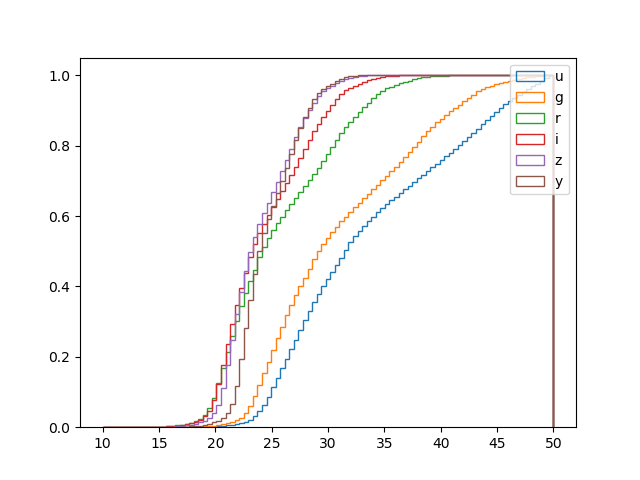

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated

In [182]:
plt.figure()
for filt in ['u','g','r','i','z','y']:
    plt.hist(sample_apparent_mag[filt],histtype='step',label=filt,bins=np.linspace(10,50,100),
             cumulative=True,normed=True)
plt.legend()

No single band is therefore always the most sensitive.  

Now let's consider an outburst.  Looking at https://www.astro.puc.cl/BlackCAT/transients.php we see that there are a wide range of outburst amplitudes in the optical.  Let's simply consider a six-mag outburst, for simplicity.

In [190]:
outburst_amplitude=6.0
is_detected_byfilt = {}
is_detected = np.zeros(nsamples).astype(np.bool)
for filt in ['u','g','r','i','z','y']:
    is_detected_byfilt[filt] = (sample_apparent_mag[filt] - outburst_amplitude) < lsst_single_epoch_depth[filt]
    is_detected |= is_detected_byfilt[filt]

In [192]:
np.sum(is_detected)

9377043

So actually just about everything is detectable in outburst in principle!  That makes me think I should just include the entire population in the metric--7% savings is not really worth losing the flexibility to later try other amplitudes, consider deeper single epoch depths, etc.